# PERSONALIZED NEWS RECOMMENDATION


In [49]:
import numpy as np
import pandas as pd

import os
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [50]:
news_articles = pd.read_json(r"C:\Users\anthe\Downloads\News_Category_Dataset_v3.json", lines = True)

In [51]:
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [52]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

In [53]:
news_articles.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY,"""Until you have a dog you don't understand what could be eaten.""",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING,"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce.""",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.,Nina Golgowski,2022-09-22


In [54]:
news_articles = news_articles[news_articles['date'] >= pd.Timestamp(2018,1,1)]

In [55]:
news_articles.shape

(17257, 6)

In [56]:
news_articles = news_articles[news_articles['headline'].apply(lambda x: len(x.split())>5)]
print("Total number of articles after removal of headlines with short title:", news_articles.shape[0])

Total number of articles after removal of headlines with short title: 17183


In [57]:
news_articles.sort_values('headline',inplace=True, ascending=False)
duplicated_articles_series = news_articles.duplicated('headline', keep = False)
news_articles = news_articles[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removing duplicates: 17113


In [58]:
news_articles.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [59]:
print("Total number of articles : ", news_articles.shape[0])
print("Total number of authors : ", news_articles["authors"].nunique())
print("Total number of unqiue categories : ", news_articles["category"].nunique())

Total number of articles :  17113
Total number of authors :  2256
Total number of unqiue categories :  36


In [60]:
news_articles_per_month = news_articles.resample('m',on = 'date')['headline'].count()
news_articles_per_month

date
2018-01-31    2065
2018-02-28    1694
2018-03-31    1778
2018-04-30    1580
2018-05-31    1391
2018-06-30     136
2018-07-31     155
2018-08-31     123
2018-09-30     156
2018-10-31     182
2018-11-30     175
2018-12-31     180
2019-01-31     181
2019-02-28     168
2019-03-31     179
2019-04-30     147
2019-05-31     152
2019-06-30     153
2019-07-31     157
2019-08-31     161
2019-09-30     163
2019-10-31     183
2019-11-30     174
2019-12-31     181
2020-01-31     154
2020-02-29     132
2020-03-31     161
2020-04-30     170
2020-05-31     179
2020-06-30     176
2020-07-31     185
2020-08-31     180
2020-09-30     172
2020-10-31     175
2020-11-30     178
2020-12-31     181
2021-01-31     183
2021-02-28     140
2021-03-31     164
2021-04-30     176
2021-05-31     184
2021-06-30     176
2021-07-31     180
2021-08-31     175
2021-09-30     168
2021-10-31     174
2021-11-30     170
2021-12-31     170
2022-01-31     149
2022-02-28     152
2022-03-31     174
2022-04-30     162
2022-05

In [61]:
news_articles.index = range(news_articles.shape[0])

In [62]:
# Adding a new column containing both day of the week and month, it will be required later while recommending based on day of the week and month
news_articles["day and month"] = news_articles["date"].dt.strftime("%a") + "_" + news_articles["date"].dt.strftime("%b")

In [63]:
news_articles_temp = news_articles.copy()

In [64]:
stop_words = set(stopwords.words('english'))

In [65]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for word in news_articles_temp["headline"][i].split():
        word = ("".join(e for e in word if e.isalnum()))
        word = word.lower()
        if not word in stop_words:
          string += word + " "  
    if(i%1000==0):
      print(i)           
    news_articles_temp.at[i,"headline"] = string.strip()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [66]:
lemmatizer = WordNetLemmatizer()

In [67]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anthe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anthe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [68]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for w in word_tokenize(news_articles_temp["headline"][i]):
        string += lemmatizer.lemmatize(w,pos = "v") + " "
    news_articles_temp.at[i, "headline"] = string.strip()
    if(i%1000==0):
        print(i)   

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [69]:
headline_vectorizer = CountVectorizer()
headline_features   = headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [70]:
headline_features.get_shape()

(17113, 16481)

In [71]:
pd.set_option('display.max_colwidth', None)

In [72]:
def bag_of_words_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features, headline_features[row_index])
    

    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    
    df = pd.DataFrame({
        'publish_date': news_articles['date'][indices].values,
        'headline': news_articles['headline'][indices].values,
        'Euclidean similarity with the queried article': couple_dist[indices].ravel(),
        'Category': news_articles['category'][indices].values  # Include category for accuracy calculation
    })
    
    print("=" * 30, "Queried article details", "=" * 30)
    print('Headline: ', news_articles['headline'][row_index])
    relevant_category = news_articles['category'][row_index]

    recommended_categories = df['Category'].values
    relevant_recommendations = sum([1 for cat in recommended_categories if cat == relevant_category])
    precision = relevant_recommendations / float(num_similar_items)

    accuracy = (relevant_recommendations / float(len(recommended_categories))) * 100 if len(recommended_categories) > 0 else 0

    print(f"Precision@{num_similar_items}: {precision:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print("\nRecommended Categories: ", recommended_categories)
    print("\n", "=" * 25, "Recommended articles: ", "=" * 23)
    return df.iloc[1:, ]

df_recommendations = bag_of_words_based_model(133, 11)  # Change the row index for any other queried article
display(df_recommendations)

============================== Queried article details ==============================
Headline:  Yovanovitch Responds To Trump Twitter Attacks In Real Time In Dramatic Impeachment Testimony
Precision@11: 0.9091
Accuracy: 90.91%

Recommended Categories:  ['POLITICS' 'POLITICS' 'POLITICS' 'POLITICS' 'POLITICS' 'POLITICS'
 'POLITICS' 'POLITICS' 'POLITICS' 'TRAVEL' 'POLITICS']

 ========================= Recommended articles:  =======================


,publish_date,headline,Euclidean similarity with the queried article,Category
1,2019-11-15,Twitter Users Smack Down Trump's Attack On Marie Yovanovitch,3.000000,POLITICS
2,2022-05-17,Donald Trump Is Back On Twitter,3.162278,POLITICS
3,2019-09-26,Here Are The Democratic Impeachment Holdouts,3.316625,POLITICS
4,2018-01-20,How The LA Times Union Won,3.316625,POLITICS
5,2019-11-16,Pelosi On Trump's Yovanovitch Attack: He Knows He's In Over His Head,3.316625,POLITICS
6,2019-10-22,Trump Likens Impeachment Inquiry To 'A Lynching' In Twitter Outburst,3.316625,POLITICS
7,2018-02-02,The Real Purpose Of The Nunes Memo,3.464102,POLITICS
8,2019-01-29,Who Congress Follows On Twitter — Exposed!,3.464102,POLITICS
9,2022-02-03,How To Salvage Your Vacation If It Rains Most Of The Time,3.464102,TRAVEL
10,2020-03-18,Solidarity In A Time Of Social Distancing,3.464102,POLITICS


In [75]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df=0.01)  
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [76]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)  
tokenizer.fit_on_texts(news_articles['headline'])

# Convert headlines to sequences
sequences = tokenizer.texts_to_sequences(news_articles['headline'])

# Pad sequences to ensure uniform length
max_sequence_length = 100  # Define maximum sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

labels = pd.get_dummies(news_articles['category']).values 


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)


# LSTM

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),  
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(labels.shape[1], activation="softmax")  
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 36)                2340      
                                                                 
Total params: 782180 (2.98 MB)
Trainable params: 782180 

In [79]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
428/428 [==============================] - 39s 87ms/step - loss: 2.3465 - accuracy: 0.3703 - val_loss: 1.9322 - val_accuracy: 0.4844
Epoch 2/10
428/428 [==============================] - 41s 95ms/step - loss: 1.7038 - accuracy: 0.5496 - val_loss: 1.5960 - val_accuracy: 0.5755
Epoch 3/10
428/428 [==============================] - 40s 93ms/step - loss: 1.3913 - accuracy: 0.6367 - val_loss: 1.5885 - val_accuracy: 0.5971
Epoch 4/10
428/428 [==============================] - 40s 93ms/step - loss: 1.2121 - accuracy: 0.6750 - val_loss: 1.6317 - val_accuracy: 0.5957
Epoch 5/10
428/428 [==============================] - 39s 92ms/step - loss: 1.0747 - accuracy: 0.7026 - val_loss: 1.6548 - val_accuracy: 0.5960
Epoch 6/10
428/428 [==============================] - 40s 92ms/step - loss: 0.9554 - accuracy: 0.7312 - val_loss: 1.8258 - val_accuracy: 0.5954
Epoch 7/10
428/428 [==============================] - 40s 94ms/step - loss: 0.8487 - accuracy: 0.7550 - val_loss: 2.0270 - val_accuracy:

In [80]:
def recommend_articles(input_headline, top_n=5):
    # Preprocess the input headline
    input_seq = tokenizer.texts_to_sequences([input_headline])
    input_padded = pad_sequences(input_seq, maxlen=max_sequence_length)

    # Predict category or relevance scores
    predictions = model.predict(input_padded)

    # Find top-n recommendations (adjust based on your use case)
    top_indices = predictions[0].argsort()[-top_n:][::-1]
    return news_articles.iloc[top_indices]

# Example usage
recommendations = recommend_articles("Breaking news about AI advancements")
print(recommendations)


1/1 [==============================] - 0s 370ms/step
                                                                                                                               link  \
16             https://www.huffpost.com/entry/the-batman-gives-movie-theaters-a-new-hope-with-big-launch_n_6224f08be4b042f866ef757c   
20  https://www.huffingtonpost.com/entry/stranger-things-fans-will-be-able-to-visit-the-upside-down-irl_us_5ac3e3a6e4b063ce2e56c26a   
8                  https://www.huffpost.com/entry/keystone-xl-pipeline-permit-us-district-judge-decision_n_5e97bf35c5b6a92100e1ee52   
14                                                https://www.huffingtonpost.com/entry/trump-hot-lawyer_us_5af5381ee4b0e57cd9f7fe84   
2                          https://www.huffpost.com/entry/cassowary-florida-worlds-dangerous-bird-attack_n_5cb30bdfe4b082aab086ecc5   

                                                                                    headline  \
16                              ‘The Bat

In [81]:
import matplotlib.pyplot as plt

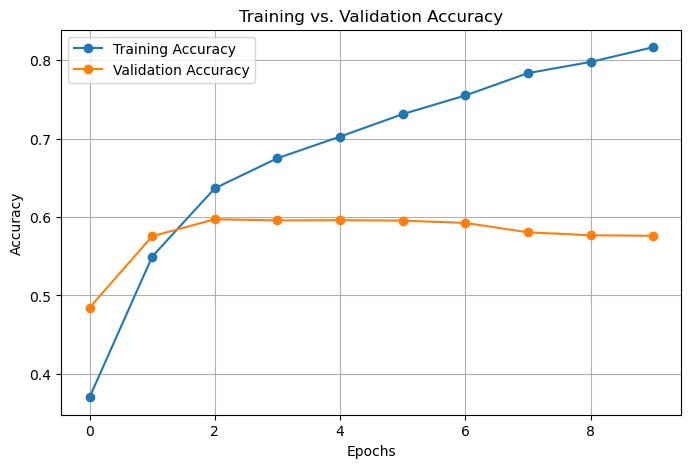

In [82]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

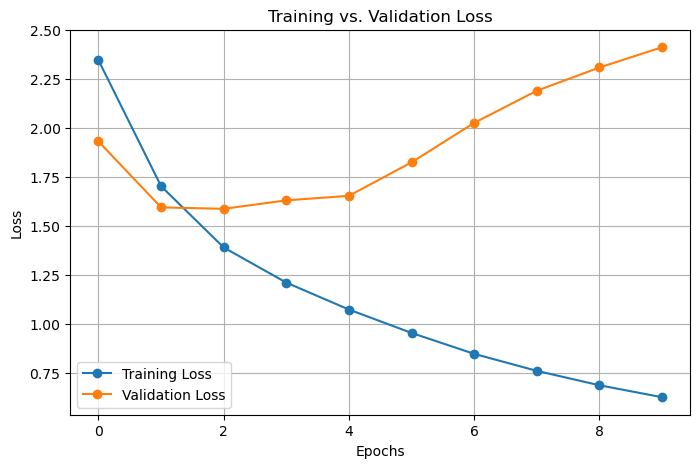

In [83]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

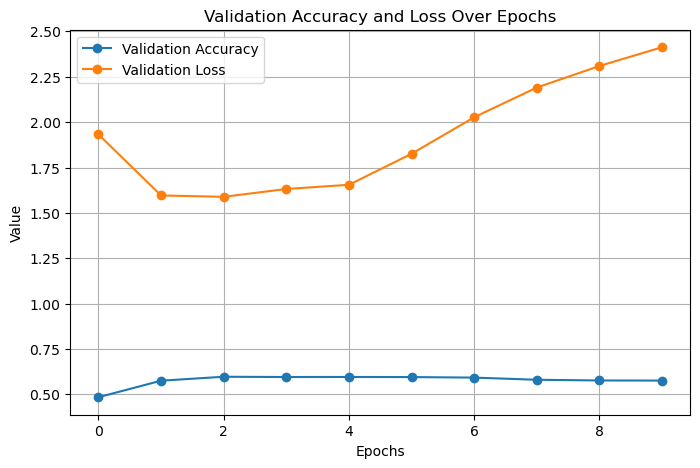

In [87]:
# Validation Accuracy/Loss Comparison Between Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Validation Accuracy and Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# CNN

In [88]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(news_articles['headline'])
sequences = tokenizer.texts_to_sequences(news_articles['headline'])

max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

labels = pd.get_dummies(news_articles['category']).values

X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)


model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),  # Reduces the sequence dimension
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(labels.shape[1], activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

def recommend_articles_cnn(input_headline, top_n=5):
    input_seq = tokenizer.texts_to_sequences([input_headline])
    input_padded = pad_sequences(input_seq, maxlen=max_sequence_length)

    predictions = model.predict(input_padded)
    top_indices = predictions[0].argsort()[-top_n:][::-1]
    return news_articles.iloc[top_indices]

recommendations_cnn = recommend_articles_cnn("Advancements in artificial intelligence")
print(recommendations_cnn)

Epoch 1/10
428/428 [==============================] - 8s 19ms/step - loss: 2.2707 - accuracy: 0.4150 - val_loss: 1.7494 - val_accuracy: 0.5355
Epoch 2/10
428/428 [==============================] - 8s 20ms/step - loss: 1.6019 - accuracy: 0.5793 - val_loss: 1.5482 - val_accuracy: 0.5930
Epoch 3/10
428/428 [==============================] - 10s 23ms/step - loss: 1.2404 - accuracy: 0.6617 - val_loss: 1.5256 - val_accuracy: 0.6185
Epoch 4/10
428/428 [==============================] - 10s 24ms/step - loss: 0.9580 - accuracy: 0.7338 - val_loss: 1.6049 - val_accuracy: 0.6190
Epoch 5/10
428/428 [==============================] - 10s 23ms/step - loss: 0.7549 - accuracy: 0.7828 - val_loss: 1.8413 - val_accuracy: 0.6164
Epoch 6/10
428/428 [==============================] - 10s 23ms/step - loss: 0.5844 - accuracy: 0.8289 - val_loss: 2.1428 - val_accuracy: 0.6077
Epoch 7/10
428/428 [==============================] - 10s 23ms/step - loss: 0.4607 - accuracy: 0.8618 - val_loss: 2.3105 - val_accuracy: 0

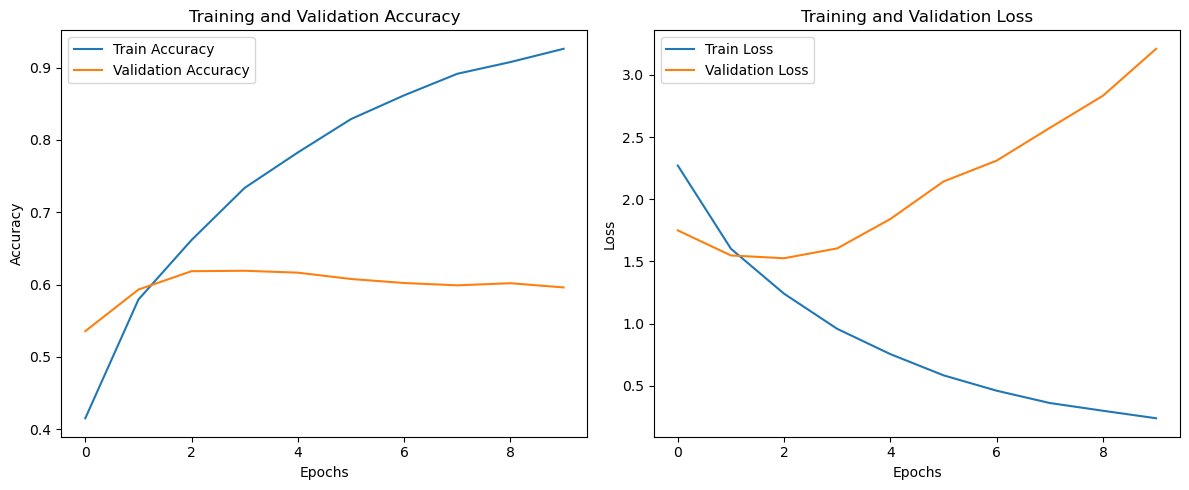

1/1 [==============================] - 0s 19ms/step
Input Headline: Advancements in artificial intelligence

Top 3 Recommendations:

Article 21:
Headline: ‘Stranger Things’ Fans Will Be Able To Visit The Upside Down IRL
Category: ENTERTAINMENT
Description: Hawkins is headed to Hollywood, Orlando and Singapore this fall.

Article 3:
Headline: ‘World’s Most Dangerous Bird’ Kills 75-Year-Old Owner In Florida
Category: U.S. NEWS
Description: Cassowaries are large, flightless birds with "dagger-like" claws. Authorities say one fatally attacked a man last week.

Article 36:
Headline: ‘RuPaul’s Drag Race All Stars 3’ Episode 4 Recap: Who Won Snatch Game?
Category: QUEER VOICES
Description: I am honestly blown back by how poorly Trixie is faring this season.



In [91]:
import matplotlib.pyplot as plt

# Training and Validation Accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_training_history(history)

# Visualize Top-N Recommendations
def visualize_recommendations(input_headline, top_n=5):
    recommendations = recommend_articles_cnn(input_headline, top_n=top_n)
    print(f"Input Headline: {input_headline}")
    print(f"\nTop {top_n} Recommendations:\n")
    for i, row in recommendations.iterrows():
        print(f"Article {i + 1}:")
        print(f"Headline: {row['headline']}")
        print(f"Category: {row['category']}")
        print(f"Description: {row['short_description']}\n")

# Example visualization for recommendations
visualize_recommendations("Advancements in artificial intelligence", top_n=3)


107/107 [==============================] - 1s 6ms/step


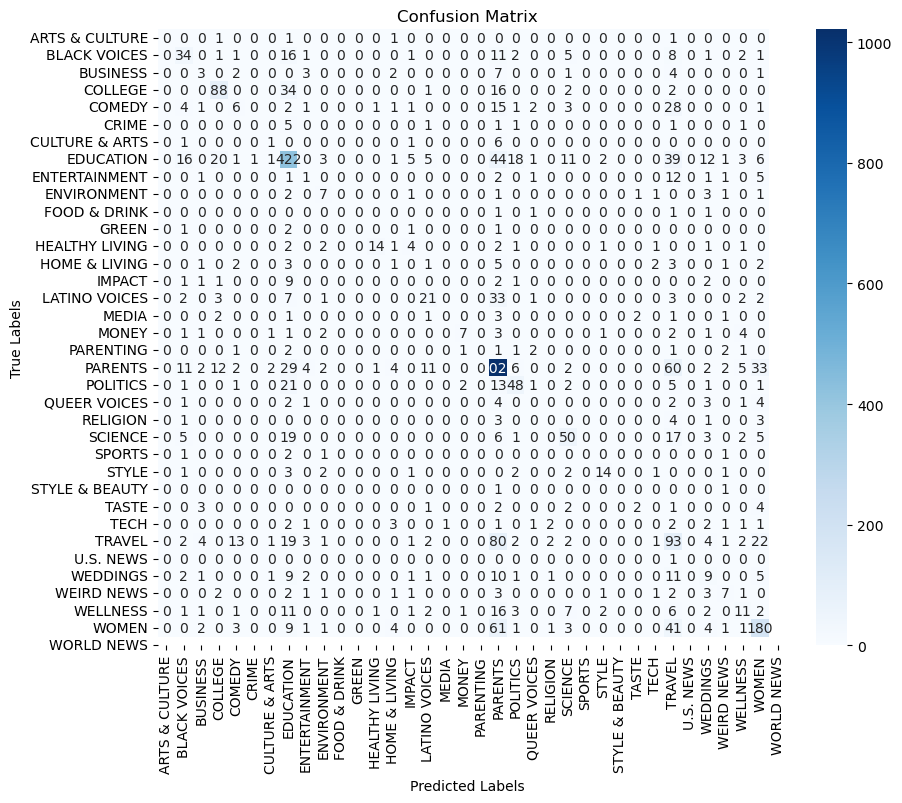

In [90]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict classes for validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the highest probability
y_true = np.argmax(y_val, axis=1)  # True class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(pd.get_dummies(news_articles['category']).columns),
            yticklabels=list(pd.get_dummies(news_articles['category']).columns))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# LOGISTIC REGRESSION

In [92]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import nltk

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

news_articles['headline'] = news_articles['headline'].apply(preprocess_text)

# TF-IDF feature extraction
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2), min_df=3, max_df=0.8)
X = tfidf.fit_transform(news_articles['headline'])
y = news_articles['category']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Recommendation function
def recommend_articles_ml(input_headline, top_n=5):
    input_headline = preprocess_text(input_headline)
    input_tfidf = tfidf.transform([input_headline])
    predicted_category = clf.predict(input_tfidf)[0]
    recommended_articles = news_articles[news_articles['category'] == predicted_category].head(top_n)
    return recommended_articles

# Example usage
recommendations_ml = recommend_articles_ml("Advancements in artificial intelligence")
print(recommendations_ml)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anthe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anthe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.628688285130003

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.00      0.00      0.00         4
  BLACK VOICES       0.70      0.36      0.47        84
      BUSINESS       0.00      0.00      0.00        23
        COMEDY       0.79      0.57      0.66       143
         CRIME       0.67      0.06      0.11        67
CULTURE & ARTS       0.00      0.00      0.00        10
     EDUCATION       0.00      0.00      0.00         9
 ENTERTAINMENT       0.59      0.81      0.68       612
   ENVIRONMENT       0.00      0.00      0.00        25
  FOOD & DRINK       1.00      0.11      0.20        18
         GREEN       0.00      0.00      0.00         4
HEALTHY LIVING       0.00      0.00      0.00         5
 HOME & LIVING       1.00      0.27      0.42        30
        IMPACT       0.00      0.00      0.00        21
 LATINO VOICES       0.00      0.00      0.00        17
         MEDIA       0.80      0.16      0.27     

C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


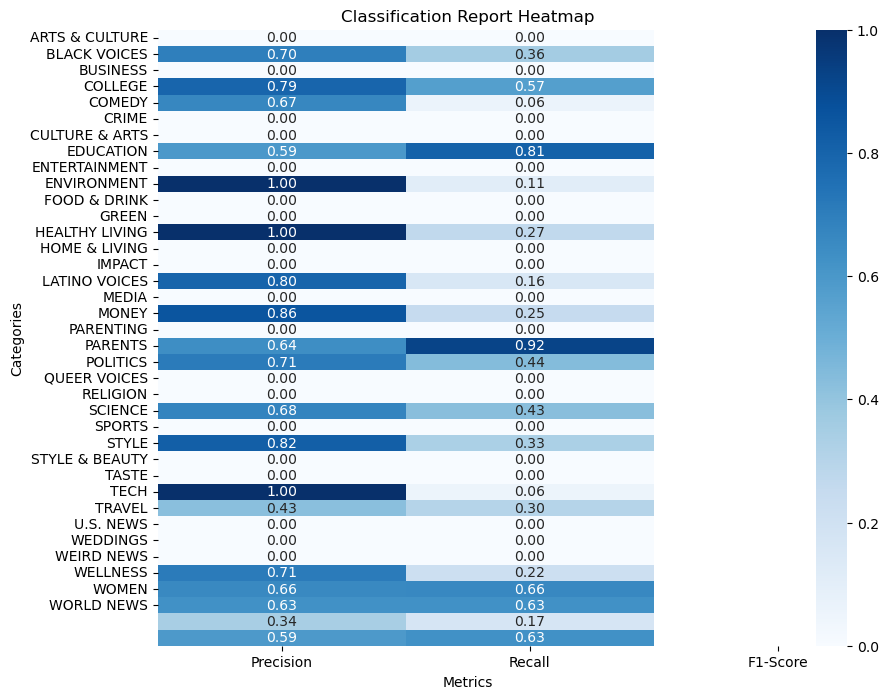

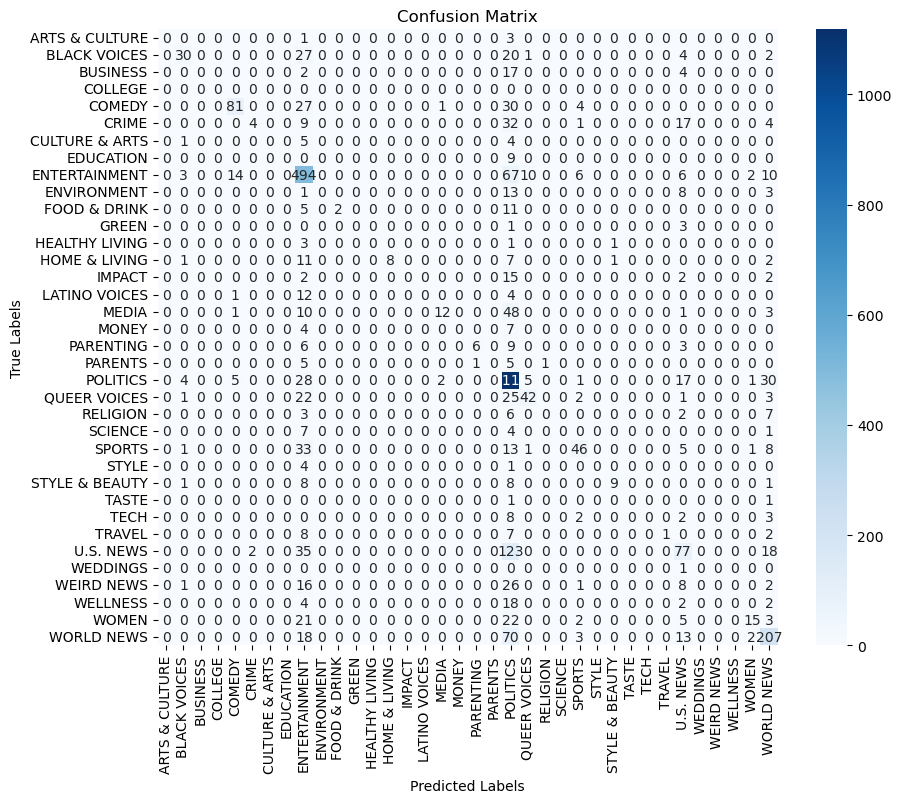

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Classification Report Heatmap
def plot_classification_report_heatmap(y_true, y_pred, categories):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy' row
    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df.iloc[:, :-1], annot=True, fmt='.2f', cmap='Blues', xticklabels=['Precision', 'Recall', 'F1-Score'])
    plt.title('Classification Report Heatmap')
    plt.xlabel('Metrics')
    plt.ylabel('Categories')
    plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=0)
    plt.show()
    
    # Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, categories):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=categories)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
categories = sorted(news_articles['category'].unique())  # Sorted category labels
plot_classification_report_heatmap(y_val, y_pred, categories)
plot_confusion_matrix(y_val, y_pred, categories)

In [94]:
# Visualize Top-N Recommendations
def visualize_recommendations_ml(input_headline, top_n=5):
    recommendations = recommend_articles_ml(input_headline, top_n=top_n)
    print(f"Input Headline: {input_headline}")
    print(f"\nTop {top_n} Recommendations:\n")
    for idx, row in recommendations.iterrows():
        print(f"Headline: {row['headline']}")
        print(f"Category: {row['category']}")
        print(f"Description: {row['short_description']}\n")

# Example visualization for recommendations
visualize_recommendations_ml("Advancements in artificial intelligence", top_n=3)

Input Headline: Advancements in artificial intelligence

Top 3 Recommendations:

Headline: kid counting father running arkansas senate
Category: POLITICS
Description: Jim Bob Duggar, who previously served in the Arkansas House, said he's running as a "bold voice that is pro-family, pro-business, pro-gun and pro-life."

Headline: woman trump cheer president mock christine blasey ford
Category: POLITICS
Description: The president ridicules his Supreme Court nominee's accuser at a Mississippi rally while women laugh and applaud.

Headline: mask going trump question use supply coronavirus case surge
Category: POLITICS
Description: Hospitals nationwide have issued pleas for protective equipment, including those in New York City, which said they only have a one-week supply left.



# XG BOOST

In [46]:
from sklearn.preprocessing import LabelEncoder

# Re-encode the target labels after SMOTE
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=300,  # Number of trees
    max_depth=6,  # Maximum tree depth
    learning_rate=0.1,  # Learning rate
    subsample=0.8,  # Row subsampling
    colsample_bytree=0.8,  # Feature subsampling
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb_model.predict(X_val)

# Evaluate the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")


C:\Users\anthe\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 0.6015


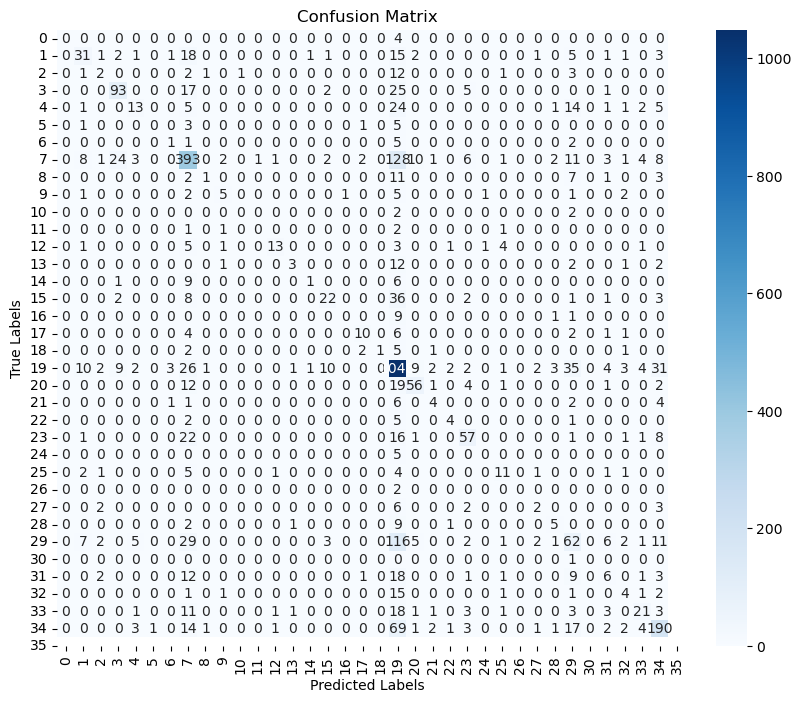

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Call the visualizations
class_labels = label_encoder.classes_
plot_confusion_matrix(y_val, y_pred, class_labels)




C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


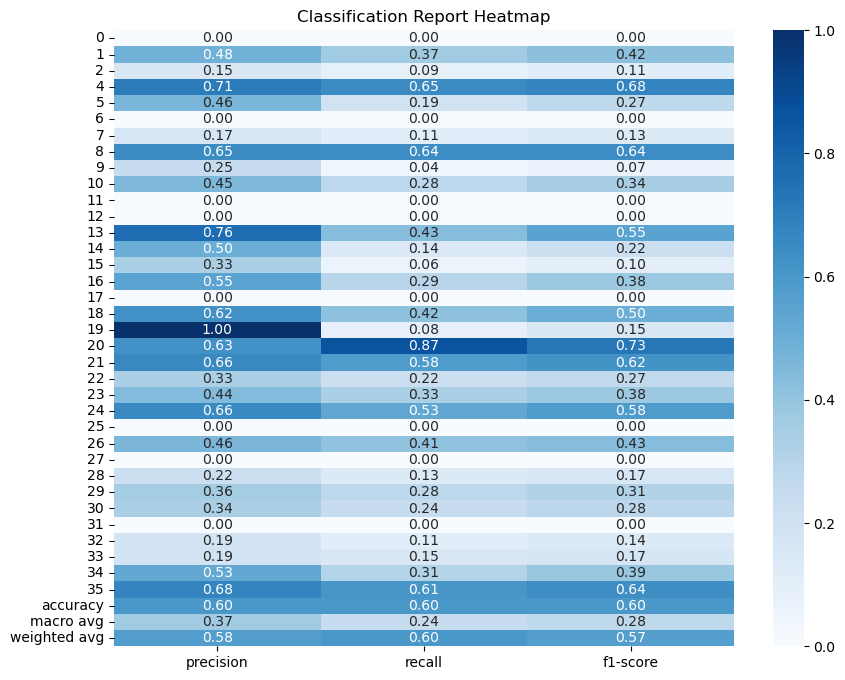

In [39]:
def plot_classification_report_heatmap(y_true, y_pred, class_labels):
    # Get unique labels in validation set
    unique_labels = sorted(set(y_true))

    # Filter class labels to match unique labels
    filtered_labels = [class_labels[i] for i in unique_labels]

    # Generate the classification report
    report = classification_report(
        y_true, y_pred, target_names=filtered_labels, output_dict=True
    )
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy' row

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Classification Report Heatmap')
    plt.show()

# Call the updated function
plot_classification_report_heatmap(y_val, y_pred, class_labels)


# SVM

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(news_articles, test_size=0.2, random_state=42)

# Encode the labels (categories)
label_encoder = LabelEncoder()
train_df['encoded_labels'] = label_encoder.fit_transform(train_df['category'])
val_df['encoded_labels'] = label_encoder.transform(val_df['category'])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_df['headline'])
X_val = tfidf_vectorizer.transform(val_df['headline'])

# Initialize the SVM model
svm_model = SVC(kernel='linear', C=1, random_state=42)

# Train the SVM model
svm_model.fit(X_train, train_df['encoded_labels'])

# Make predictions on the validation set
y_pred = svm_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(val_df['encoded_labels'], y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Example usage: Predicting the category of a new headline
def predict_category_svm(headline):
    headline_tfidf = tfidf_vectorizer.transform([headline])
    predicted_label = svm_model.predict(headline_tfidf)[0]
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]
    return predicted_category

# Predict a category for a new headline
new_headline = "Advancements in artificial intelligence"
predicted_category = predict_category_svm(new_headline)
print(f"Predicted Category for '{new_headline}': {predicted_category}")


Accuracy: 63.42%
Predicted Category for 'Advancements in artificial intelligence': POLITICS


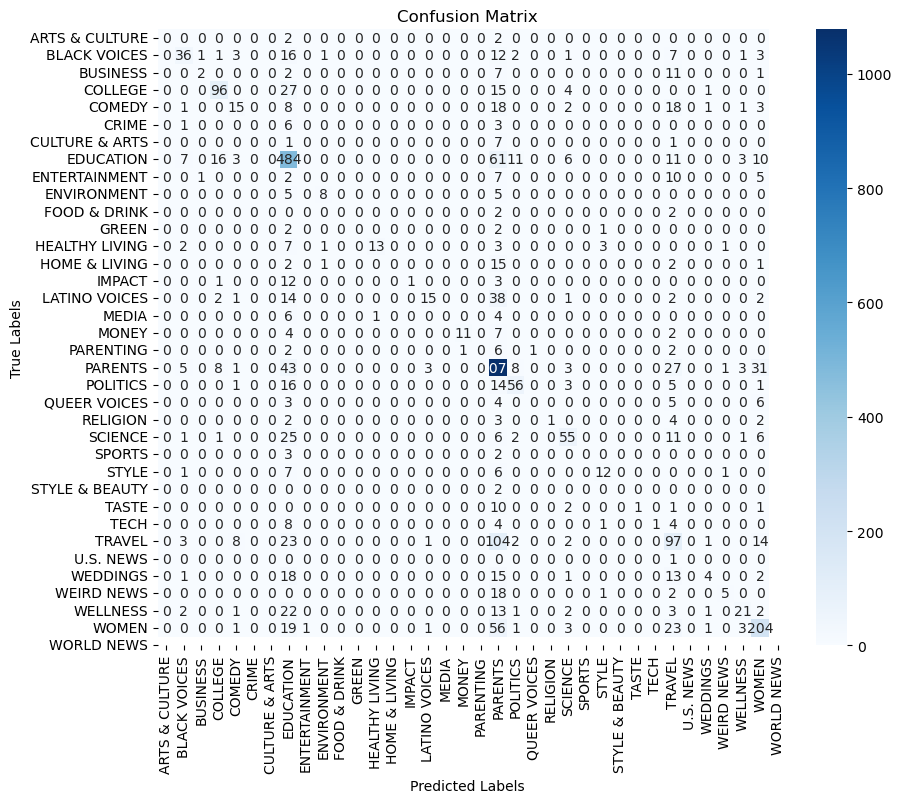

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Get class labels
class_labels = label_encoder.classes_

# Plot Confusion Matrix
plot_confusion_matrix(val_df['encoded_labels'], y_pred, class_labels)


C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anthe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


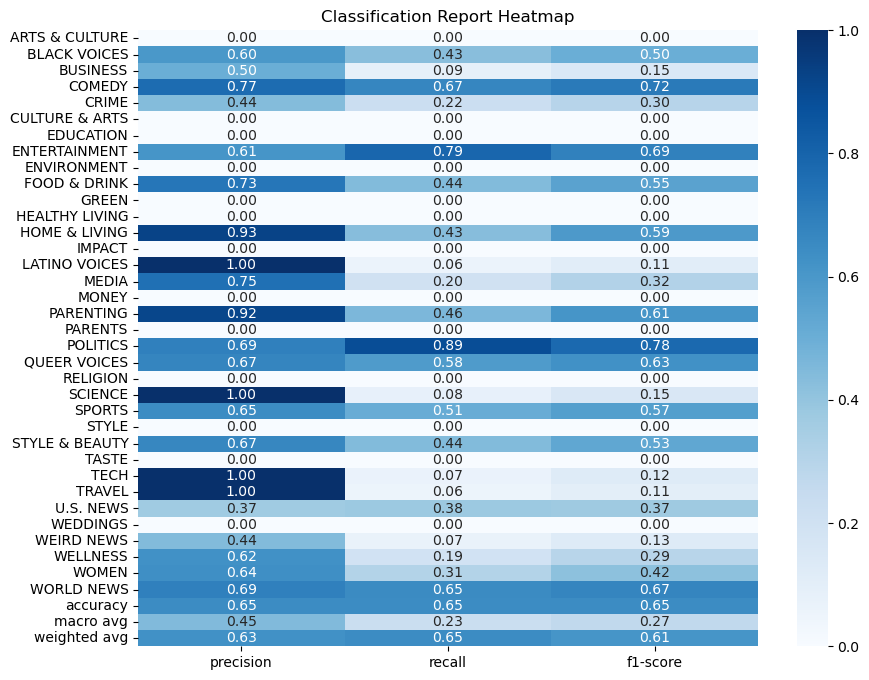

In [33]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_classification_report_heatmap(y_true, y_pred, class_labels):
    # Get unique labels in the validation set
    unique_labels = sorted(set(y_true))

    # Filter class labels to match the unique labels
    filtered_labels = [class_labels[i] for i in unique_labels]

    # Generate the classification report
    report = classification_report(
        y_true, y_pred, target_names=filtered_labels, output_dict=True
    )
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy' row

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Classification Report Heatmap')
    plt.show()

# Plot Classification Report Heatmap
plot_classification_report_heatmap(val_df['encoded_labels'], y_pred, class_labels)


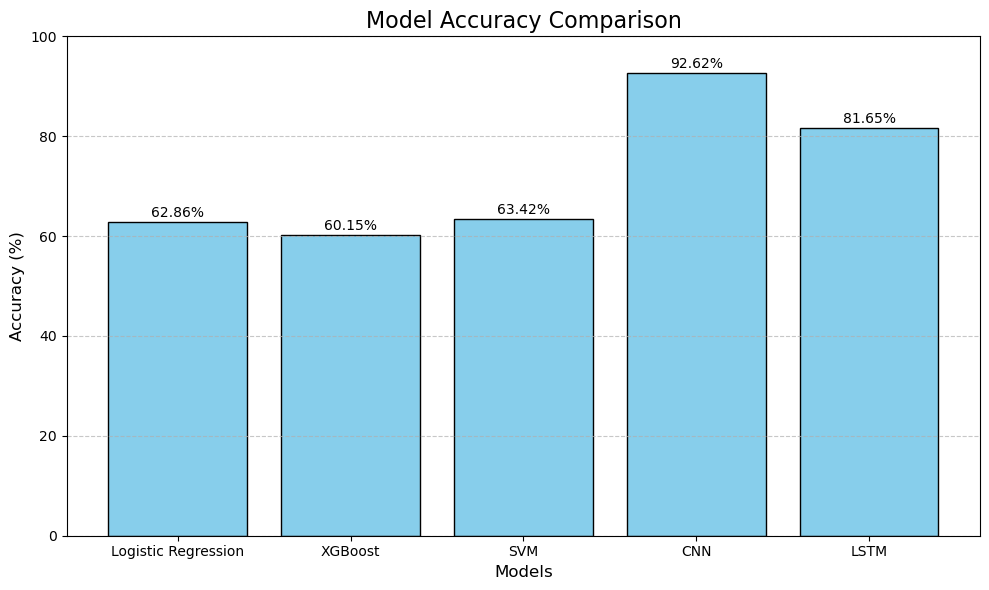

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Example accuracies for each model (replace with actual values)
models = ['Logistic Regression', 'XGBoost', 'SVM', 'CNN', 'LSTM']
accuracies = [62.86, 60.15, 63.42, 92.62, 81.65]  # Replace with actual accuracy percentages

# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue', edgecolor='black')

# Adding labels, title, and formatting
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylim(0, 100)  # Accuracy ranges from 0% to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding accuracy values on top of bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 1, f'{accuracy:.2f}%', ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
